In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                           | 0/50000 [00:00<?, ?it/s]

  7%|█████████▌                                                                                                                                   | 3405/50000 [00:00<00:01, 34044.43it/s]

 14%|███████████████████▊                                                                                                                         | 7013/50000 [00:00<00:01, 35240.03it/s]

 21%|█████████████████████████████▌                                                                                                              | 10578/50000 [00:00<00:01, 35423.46it/s]

 29%|████████████████████████████████████████▊                                                                                                   | 14566/50000 [00:00<00:00, 37179.64it/s]

 37%|███████████████████████████████████████████████████▉                                                                                        | 18561/50000 [00:00<00:00, 38175.76it/s]

 45%|███████████████████████████████████████████████████████████████▎                                                                            | 22622/50000 [00:00<00:00, 39000.50it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                 | 26523/50000 [00:00<00:00, 38896.37it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                      | 30413/50000 [00:00<00:00, 38073.67it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 34503/50000 [00:00<00:00, 38942.70it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 38633/50000 [00:01<00:00, 39660.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42603/50000 [00:01<00:00, 39432.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 46749/50000 [00:01<00:00, 40042.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 38657.36it/s]

Files already downloaded and verified


  0%|                                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

 36%|███████████████████████████████████████████████████▎                                                                                         | 3637/10000 [00:00<00:00, 36366.05it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7692/10000 [00:00<00:00, 38818.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 38947.58it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 5izbkda2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-5izbkda2:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.3


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_rcn = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_rcn = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_rcn = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_rcn = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_rcn = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                             | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/313 [00:00<02:33,  2.03it/s]

  7%|█████████▉                                                                                                                                          | 21/313 [00:00<00:06, 46.02it/s]

 13%|███████████████████▍                                                                                                                                | 41/313 [00:00<00:03, 82.50it/s]

 19%|████████████████████████████▋                                                                                                                      | 61/313 [00:00<00:02, 111.54it/s]

 26%|██████████████████████████████████████                                                                                                             | 81/313 [00:00<00:01, 134.12it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 101/313 [00:01<00:01, 151.16it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 121/313 [00:01<00:01, 162.86it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                                | 140/313 [00:01<00:01, 170.14it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 160/313 [00:01<00:00, 177.03it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 180/313 [00:01<00:00, 182.46it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 200/313 [00:01<00:00, 185.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 220/313 [00:01<00:00, 188.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 240/313 [00:01<00:00, 190.63it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 260/313 [00:01<00:00, 191.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 280/313 [00:01<00:00, 192.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 300/313 [00:02<00:00, 193.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 143.55it/s]

train - OK


  0%|                                                                                                                                                              | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                    | 1/79 [00:00<00:09,  8.31it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 21/79 [00:00<00:00, 109.40it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 41/79 [00:00<00:00, 146.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 61/79 [00:00<00:00, 165.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 146.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 129.25it/s]

val - OK


  0%|                                                                                                                                                              | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                    | 1/79 [00:00<00:09,  8.00it/s]

 24%|███████████████████████████████████▊                                                                                                                 | 19/79 [00:00<00:00, 98.96it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                           | 39/79 [00:00<00:00, 139.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 59/79 [00:00<00:00, 159.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 172.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.03it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/469 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                    | 1/469 [00:00<01:03,  7.32it/s]

  4%|██████▎                                                                                                                                            | 20/469 [00:00<00:04, 100.28it/s]

  9%|████████████▌                                                                                                                                      | 40/469 [00:00<00:03, 140.14it/s]

 13%|██████████████████▊                                                                                                                                | 60/469 [00:00<00:02, 160.40it/s]

 17%|█████████████████████████                                                                                                                          | 80/469 [00:00<00:02, 172.10it/s]

 21%|███████████████████████████████▏                                                                                                                  | 100/469 [00:00<00:02, 179.26it/s]

 26%|█████████████████████████████████████▎                                                                                                            | 120/469 [00:00<00:01, 183.67it/s]

 30%|███████████████████████████████████████████▌                                                                                                      | 140/469 [00:00<00:01, 186.92it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 160/469 [00:00<00:01, 188.88it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 180/469 [00:01<00:01, 190.37it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 200/469 [00:01<00:01, 191.23it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 220/469 [00:01<00:01, 190.70it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 240/469 [00:01<00:01, 191.47it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 260/469 [00:01<00:01, 192.28it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 280/469 [00:01<00:00, 192.67it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 300/469 [00:01<00:00, 192.96it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 320/469 [00:01<00:00, 193.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 340/469 [00:01<00:00, 193.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 360/469 [00:01<00:00, 193.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 380/469 [00:02<00:00, 193.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 400/469 [00:02<00:00, 193.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 420/469 [00:02<00:00, 193.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 440/469 [00:02<00:00, 192.72it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 460/469 [00:02<00:00, 192.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 176.74it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:00, 193.40it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:00, 196.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:00<00:00, 199.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:00<00:00, 199.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199.45it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

ind_ftr = ind_emb
if ood_str:
    ood_ftr = ood_emb
n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


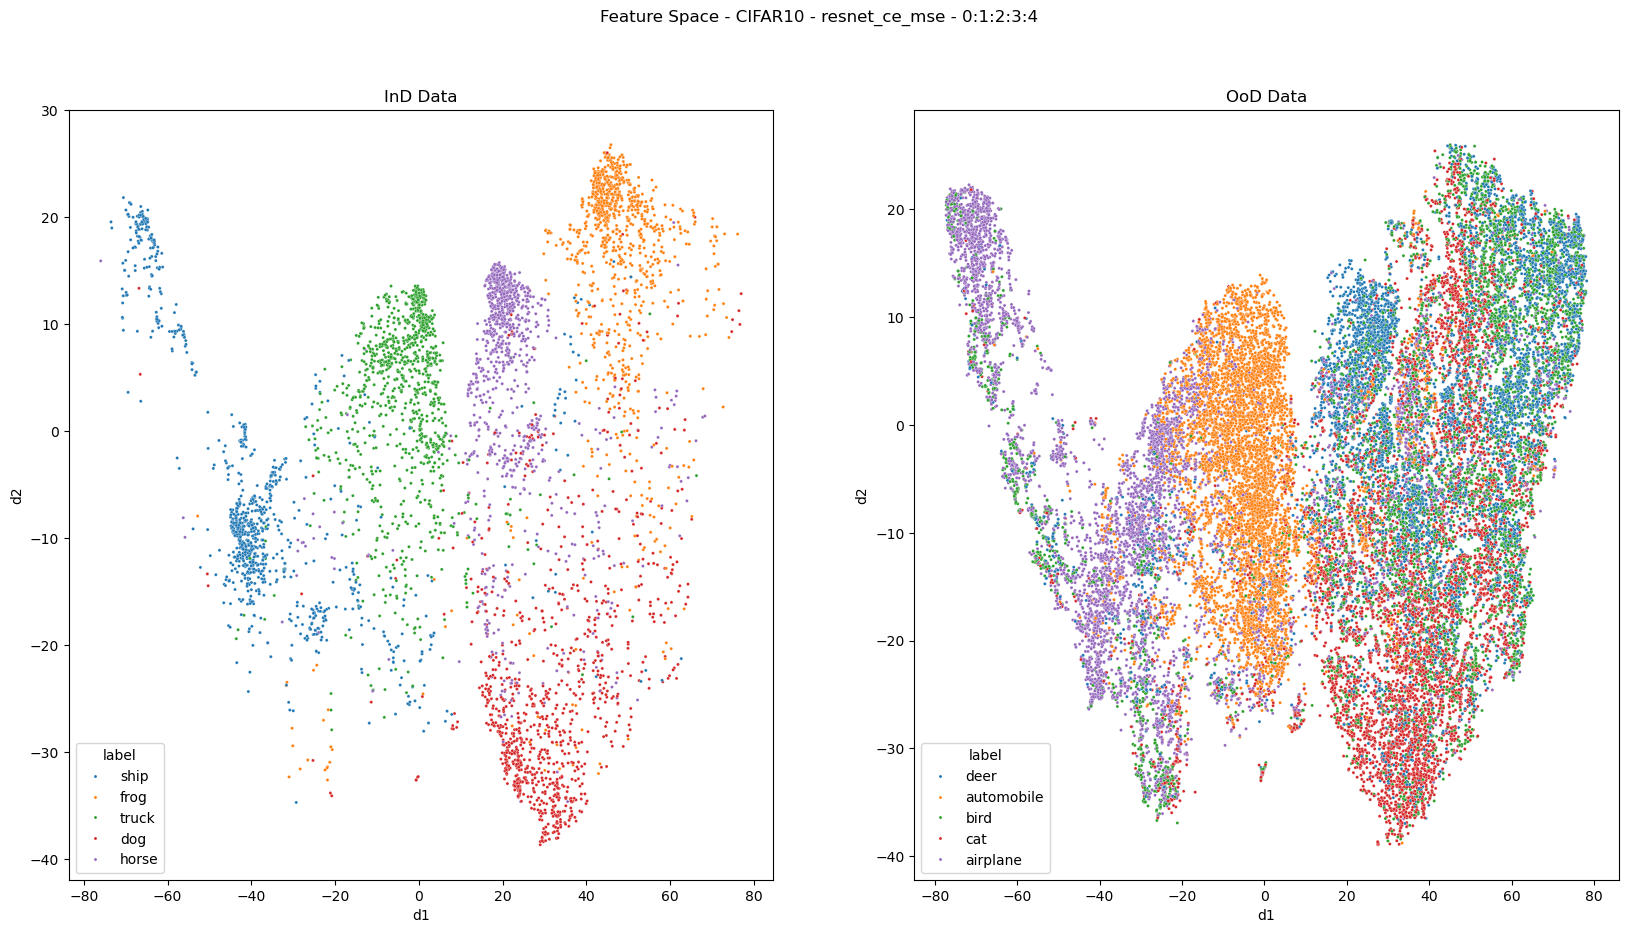

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

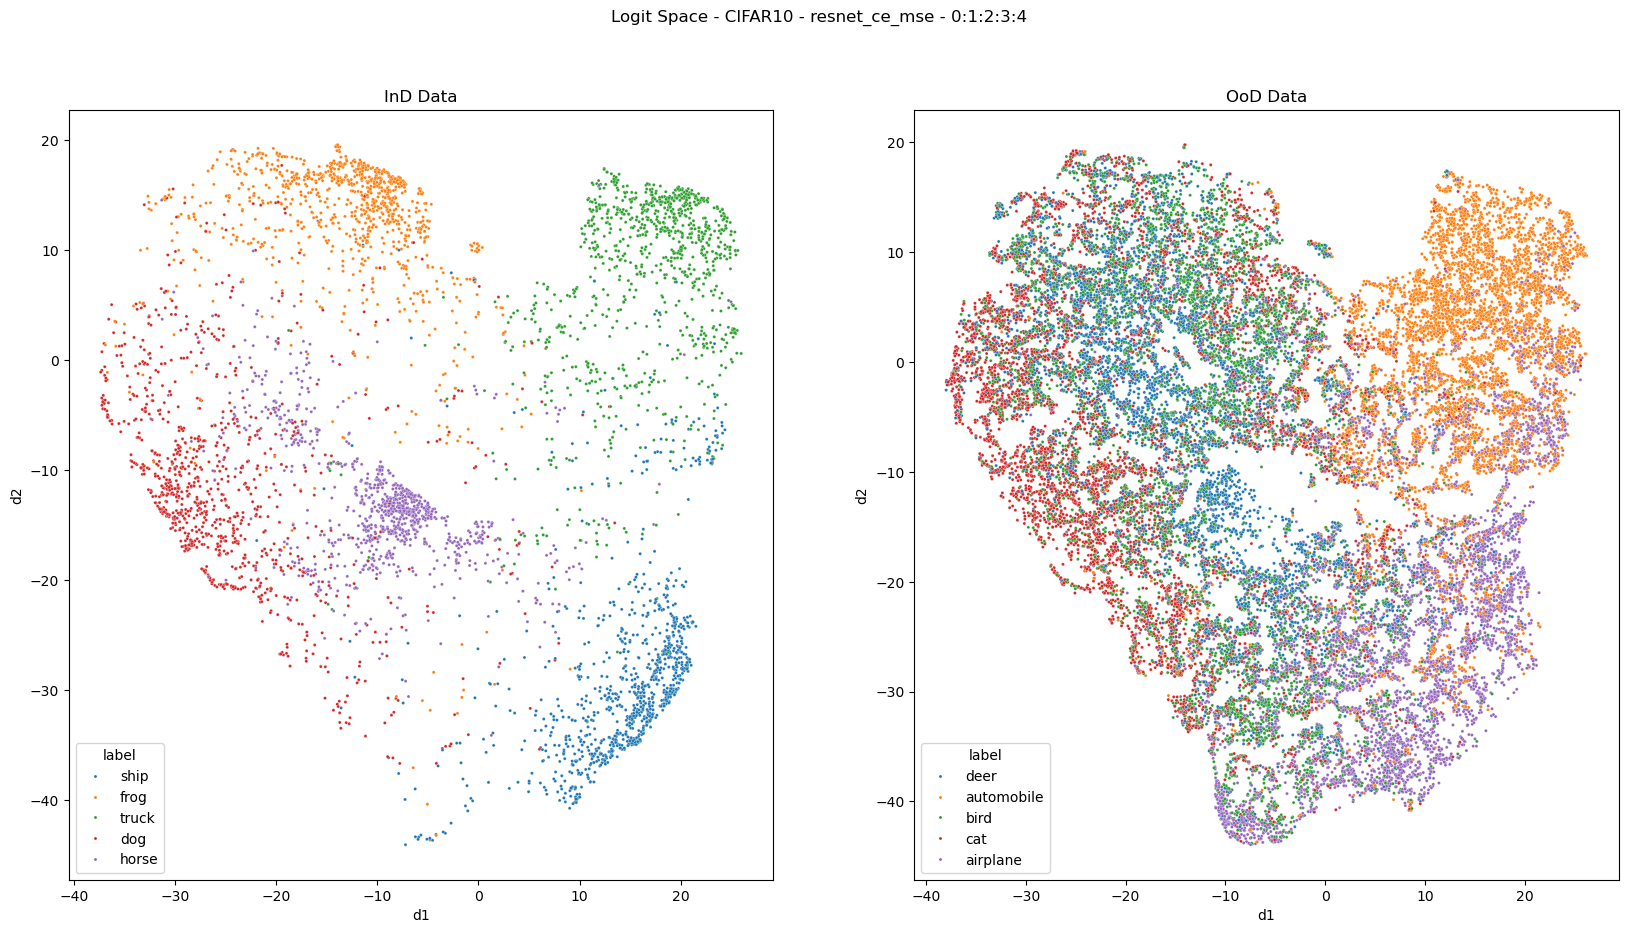

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:03,  1.30s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:02<00:02,  1.43s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:04<00:01,  1.41s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/it]

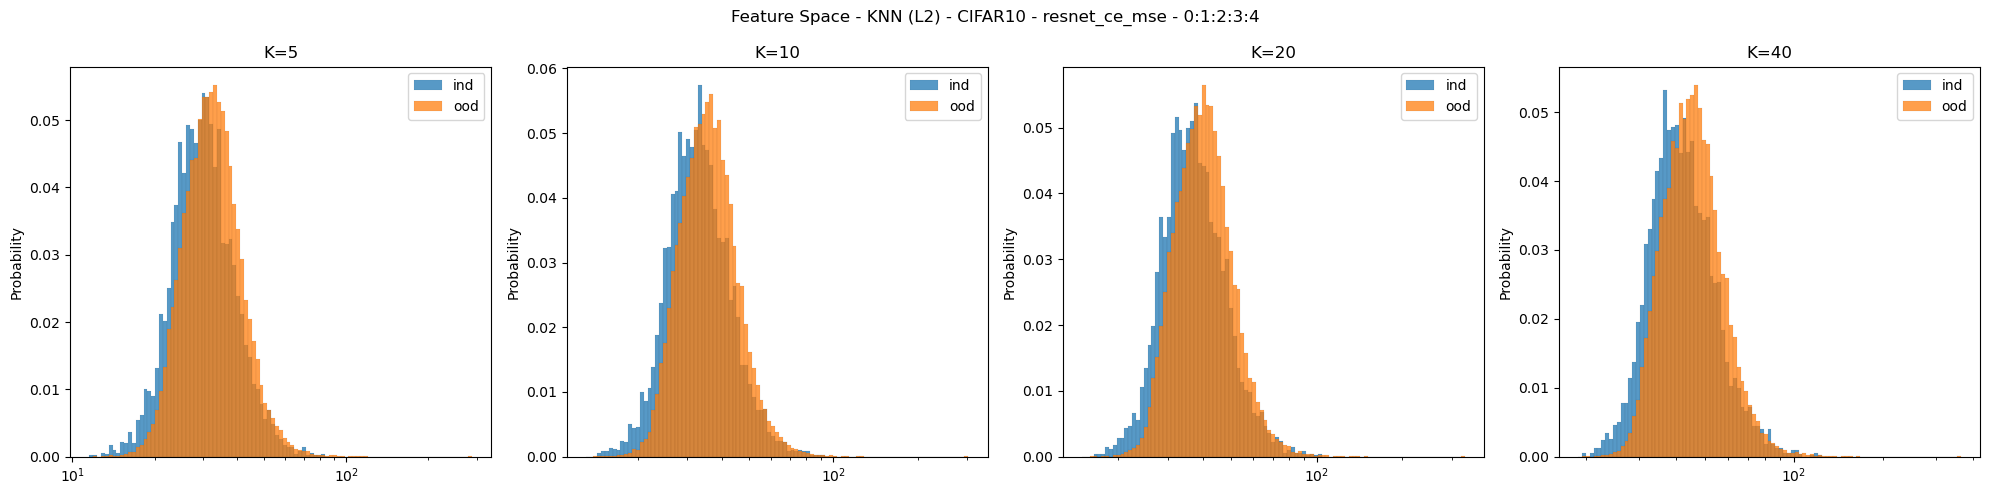

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:03,  1.18s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:02<00:02,  1.20s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:03<00:01,  1.24s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it]

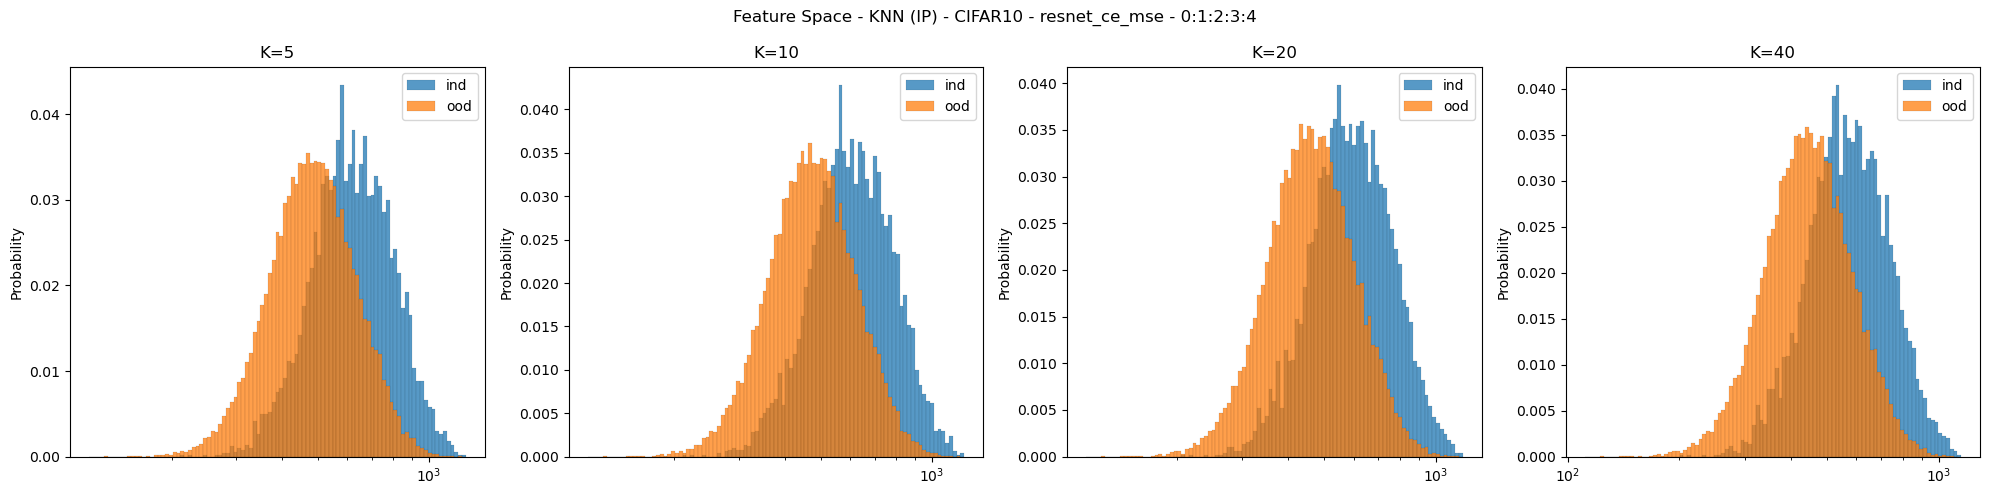

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:03,  1.18s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:02<00:02,  1.20s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:03<00:01,  1.24s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]

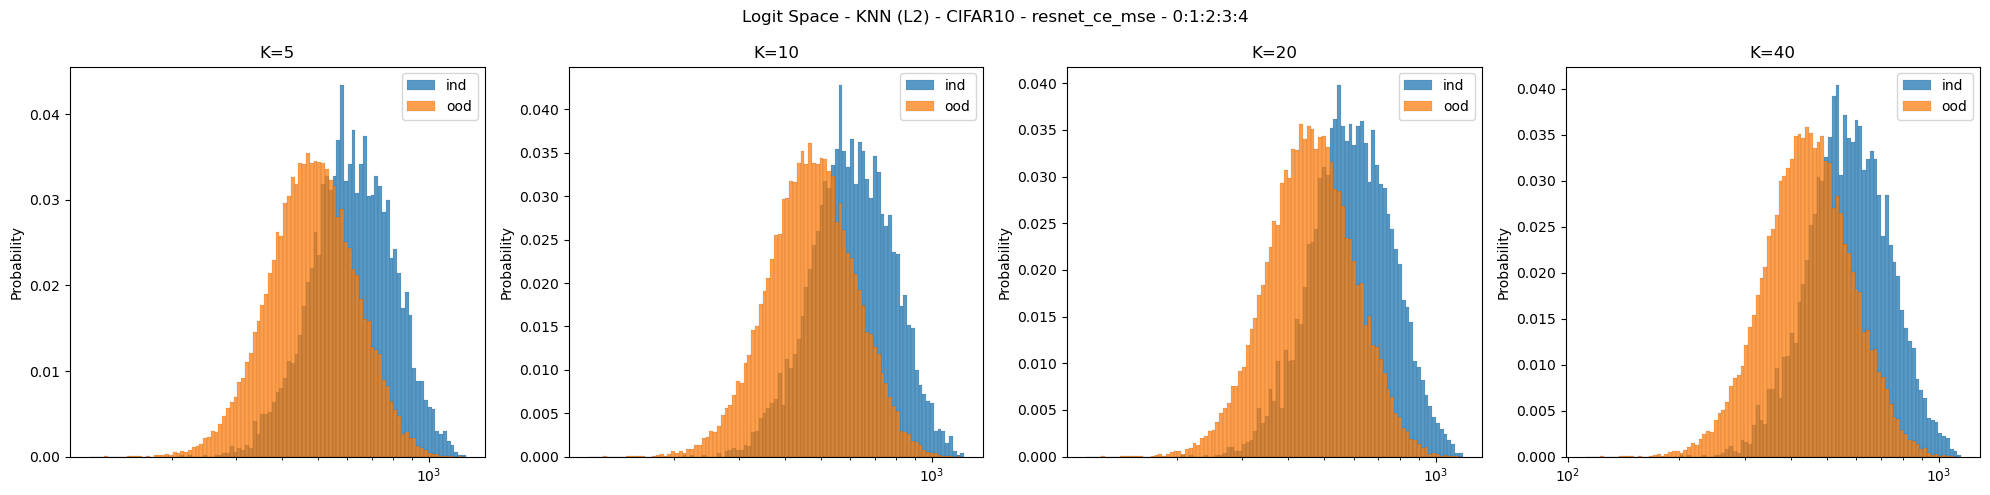

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:03,  1.18s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:02<00:02,  1.20s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:03<00:01,  1.38s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]

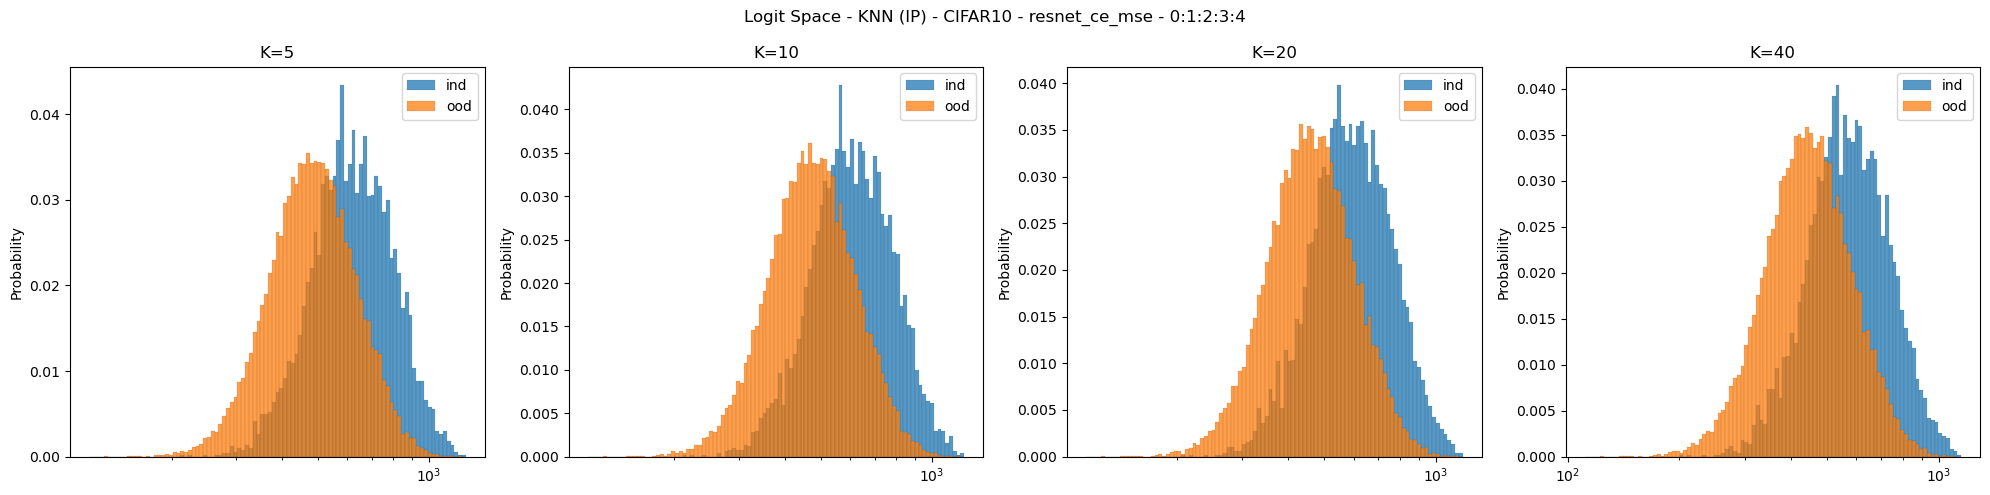

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

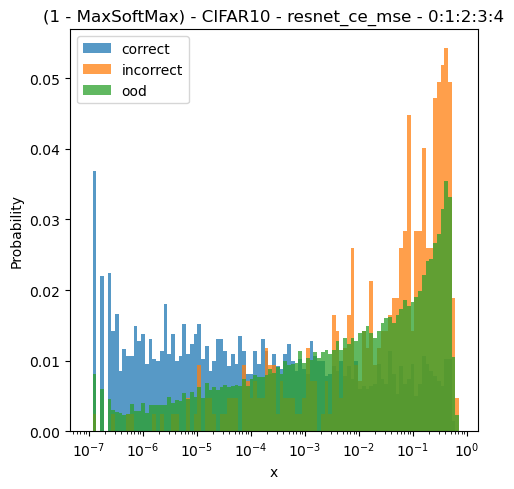

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()